# **Smart Anti Covid Room**

The objective is trying to estimate the social distancing among a set of people, with a non-bird-eye camera.

Several different models for object detection, downloaded from https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md, are compared to estimate which one is the best for using it in a real application of the system.

The main reference for this project is described at this page: https://medium.com/@birla.deepak26/social-distancing-ai-using-python-deep-learning-c26b20c9aa4c .

[DA METTERE NELLA SEZIONE SUA The reference for the neural network is : https://docs.openvino.ai/latest/omz_models_model_mobilenet_ssd.html .]


## Imports

In [380]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder

import numpy as np
import matplotlib.pyplot as plt
import random
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.platform import gfile
from keras.models import Model
import glob
from PIL import Image
import xml.etree.ElementTree as ET
import cv2
import itertools as iter

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import time
import pandas as pd

# Test set
---

To compare the models on a simulated real application a custom dataset has been created

In [3]:
def load_label(label_path):
    bboxes = []
    with open(label_path, 'r') as label_file:
        for l in label_file:
            l = l.rstrip().lstrip("[").rstrip("]").split()
            bbox = np.asarray(l).astype(int)
            bboxes.append(bbox)
    return np.asarray(bboxes)

def load_data(images_folder_path, labels_folder_path):
    image_list=[]
    label_list=[]
    images_path_list=sorted(glob.glob(images_folder_path+'/*'))
    labels_path_list=sorted(glob.glob(labels_folder_path+'/*'))
    for image_path, label_path in zip(images_path_list, labels_path_list):
        image = Image.open(image_path)
        image_list.append(np.asarray(image)[:,:,:3])
        label_list.append(load_label(label_path))
    
    return np.asarray(image_list), np.asarray(label_list)

In [42]:
test_images_path = "testset/frames"
label_images_path = "testset/labels"
test_set, labels = load_data(test_images_path, label_images_path)
violation_labels = [l[-1:][0][0] for l in labels]
test_set_size = test_set.shape[0]
print("Number of images in the testset: ", test_set_size)

/public.hpc/marta.spadoni2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Number of images in the testset:  163


/public.hpc/marta.spadoni2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Visualizing images

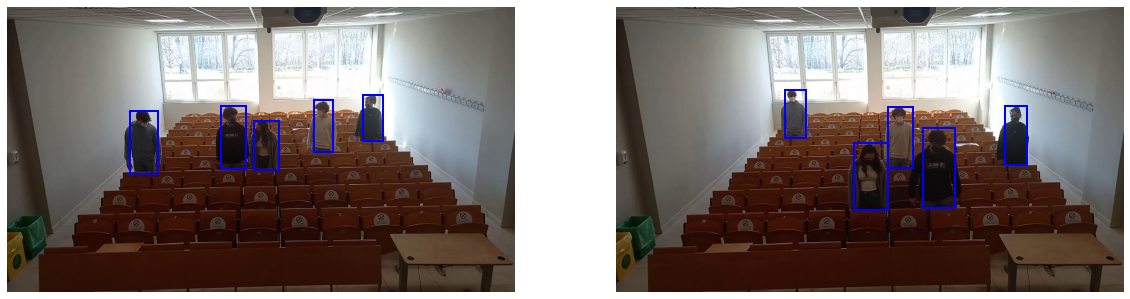

In [499]:
_, axs = plt.subplots(1, 2,figsize=(20, 10))
for i in range(2):
    random_idx=random.randint(0,test_set_size)
    axs[i].imshow(test_set[random_idx])
    axs[i].axis('off')
    for box in labels[random_idx][:-1]:
        xmin = box[0]
        ymin = box[1]
        xmax = box[2]
        ymax = box[3]
        axs[i].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='blue', fill=False, linewidth=2))  

In [395]:
def add_model(model_name, short_model_name, models_list):
    model = tf.saved_model.load(model_name+"/saved_model")
    model_dict = {
        'model_name' : model_name,
        'short_name': short_model_name,
        'model' : model
    }
    models_list.append(model_dict)
    return models_list

In [508]:
models_list = []

# Load SSD-MobileNetV2 FPNlite model

---

This model has been trained on the COCO dataset a standard dataset for object detection.

Inference Speed: 22ms 
COCO mAP: 22.2

In [30]:
!wget "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz"
!tar -xvzf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!rm ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

--2022-03-25 11:19:37--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2a00:1450:4002:405::2010, 142.250.184.80
Connecting to download.tensorflow.org (download.tensorflow.org)|2a00:1450:4002:405::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  27.5MB/s    in 0.7s    

2022-03-25 11:19:38 (27.5 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320

In [509]:
models_list = add_model("ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8", "ssd_mobilenetV2_fpnlite", models_list)

In [8]:
model = tf.saved_model.load("ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model")

2022-03-28 14:32:38.273061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 14:32:38.301946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 14:32:38.302433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 14:32:38.303681: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Load CenterNet Resnet50 v2 model
---
This model has been trained on the COCO dataset a standard dataset for object detection. 

Inference Speed: 27ms COCO mAP: 29.5

In [217]:
!wget "http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v2_512x512_coco17_tpu-8.tar.gz"
!tar -xvzf centernet_resnet50_v2_512x512_coco17_tpu-8.tar.gz
!rm centernet_resnet50_v2_512x512_coco17_tpu-8.tar.gz

--2022-03-25 14:54:01--  http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v2_512x512_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2a00:1450:4002:405::2010, 142.250.184.80
Connecting to download.tensorflow.org (download.tensorflow.org)|2a00:1450:4002:405::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 237977273 (227M) [application/x-tar]
Saving to: ‘centernet_resnet50_v2_512x512_coco17_tpu-8.tar.gz’

centernet_resnet50_ 100%[===================>] 226.95M  53.8MB/s    in 4.7s    

2022-03-25 14:54:07 (47.9 MB/s) - ‘centernet_resnet50_v2_512x512_coco17_tpu-8.tar.gz’ saved [237977273/237977273]

centernet_resnet50_v2_512x512_coco17_tpu-8/
centernet_resnet50_v2_512x512_coco17_tpu-8/checkpoint/
centernet_resnet50_v2_512x512_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
centernet_resnet50_v2_512x512_coco17_tpu-8/checkpoint/checkpoint
centernet_resnet50_v2_512x512_coco17_tpu-8/checkp

In [510]:
models_list = add_model("centernet_resnet50_v2_512x512_coco17_tpu-8", "cn_resnet50V2", models_list)

In [175]:
model = tf.saved_model.load("centernet_resnet50_v2_512x512_coco17_tpu-8/saved_model")

# Load CenterNet Resnet50 v1 FPN model
---
This model has been trained on the COCO dataset a standard dataset for object detection. 

Inference Speed: 27ms COCO mAP: 31.2

In [268]:
!wget "http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v1_fpn_512x512_coco17_tpu-8.tar.gz"
!tar -xvzf centernet_resnet50_v1_fpn_512x512_coco17_tpu-8.tar.gz
!rm centernet_resnet50_v1_fpn_512x512_coco17_tpu-8.tar.gz

--2022-03-29 11:59:00--  http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v1_fpn_512x512_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2a00:1450:4002:405::2010, 142.250.184.80
Connecting to download.tensorflow.org (download.tensorflow.org)|2a00:1450:4002:405::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 204067969 (195M) [application/x-tar]
Saving to: ‘centernet_resnet50_v1_fpn_512x512_coco17_tpu-8.tar.gz’

centernet_resnet50_ 100%[===================>] 194.61M  48.2MB/s    in 4.1s    

2022-03-29 11:59:04 (47.3 MB/s) - ‘centernet_resnet50_v1_fpn_512x512_coco17_tpu-8.tar.gz’ saved [204067969/204067969]

centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/
centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/checkpoint/
centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/checkpoint/checkpoint
centernet_resnet50_v1

In [511]:
models_list = add_model("centernet_resnet50_v1_fpn_512x512_coco17_tpu-8", "cn_resnet50V1_fpn", models_list)

In [303]:
model = tf.saved_model.load("centernet_resnet50_v1_fpn_512x512_coco17_tpu-8/saved_model")

# Load SSD MobileNet v2 model
---
This model has been trained on the COCO dataset a standard dataset for object detection. 

Inference Speed: 19ms COCO mAP: 20.2

In [84]:
!wget "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz"
!tar -xvzf ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
!rm ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz

--2022-03-25 12:01:38--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2a00:1450:4002:406::2010, 142.250.184.112
Connecting to download.tensorflow.org (download.tensorflow.org)|2a00:1450:4002:406::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46042990 (44M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_32 100%[===================>]  43.91M  49.1MB/s    in 0.9s    

2022-03-25 12:01:39 (49.1 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’ saved [46042990/46042990]

ssd_mobilenet_v2_320x320_coco17_tpu-8/
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_mobilenet_v2_320x320_

In [512]:
models_list = add_model("ssd_mobilenet_v2_320x320_coco17_tpu-8", "ssd_mobilenetV2", models_list)

In [214]:
model = tf.saved_model.load("ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model")

# EfficientDet D0 model
---
This model has been trained on the COCO dataset a standard dataset for object detection.

Inference Speed: 39ms COCO mAP: 33.6

In [225]:
!wget "http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz"
!tar -xvzf efficientdet_d0_coco17_tpu-32.tar.gz
!rm efficientdet_d0_coco17_tpu-32.tar.gz

--2022-03-28 16:07:09--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2a00:1450:4002:405::2010, 142.250.184.80
Connecting to download.tensorflow.org (download.tensorflow.org)|2a00:1450:4002:405::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M  48.0MB/s    in 0.6s    

2022-03-28 16:07:10 (48.0 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]

efficientdet_d0_coco17_tpu-32/
efficientdet_d0_coco17_tpu-32/checkpoint/
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d0_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d0_coco17_tpu-32/pipeline.config
efficientdet_d0_coco17_tpu-32/saved_model/
e

In [513]:
models_list = add_model("efficientdet_d0_coco17_tpu-32", "efficientdet_d0", models_list)

In [291]:
model = tf.saved_model.load("efficientdet_d0_coco17_tpu-32/saved_model")

# CenterNet Resnet101 V1 FPN model

This model has been trained on the COCO dataset a standard dataset for object detection.

Inference Speed: 34ms COCO mAP: 34.2


In [249]:
!wget "http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet101_v1_fpn_512x512_coco17_tpu-8.tar.gz"
!tar -xvzf centernet_resnet101_v1_fpn_512x512_coco17_tpu-8.tar.gz
!rm centernet_resnet101_v1_fpn_512x512_coco17_tpu-8.tar.gz

--2022-03-28 16:20:22--  http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet101_v1_fpn_512x512_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2a00:1450:4002:405::2010, 142.250.184.80
Connecting to download.tensorflow.org (download.tensorflow.org)|2a00:1450:4002:405::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345992335 (330M) [application/x-tar]
Saving to: ‘centernet_resnet101_v1_fpn_512x512_coco17_tpu-8.tar.gz’

centernet_resnet101 100%[===================>] 329.96M  80.4MB/s    in 4.1s    

2022-03-28 16:20:26 (81.1 MB/s) - ‘centernet_resnet101_v1_fpn_512x512_coco17_tpu-8.tar.gz’ saved [345992335/345992335]

centernet_resnet101_v1_fpn_512x512_coco17_tpu-8/
centernet_resnet101_v1_fpn_512x512_coco17_tpu-8/checkpoint/
centernet_resnet101_v1_fpn_512x512_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
centernet_resnet101_v1_fpn_512x512_coco17_tpu-8/checkpoint/checkpoint
centernet_resn

In [514]:
models_list = add_model("centernet_resnet101_v1_fpn_512x512_coco17_tpu-8", "cn_resnet101V1_fpn", models_list)

In [250]:
model = tf.saved_model.load("centernet_resnet101_v1_fpn_512x512_coco17_tpu-8/saved_model")

# SSD300

In [515]:
img_height = 300 # Altezza dell'immagine di input del modello
img_width = 300 # Larghezza dell'immagine di input del modello
img_channels = 3 # Numero di canali dell'immagine di input del modello
n_classes = 20 # Numero di classi del problema (indice classe person: 15)
scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # Fattori di scala delle default box
aspect_ratios = [[1.0, 2.0, 0.5], # Aspect ratio delle default box per ogni predictor layer
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] 
steps = [8, 16, 32, 64, 100, 300] # Distanza tra default box adiacenti per ogni predictor layer
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # Offset del centro della prima default box rispetto al bordo dell'immagine riportato come frazione dello step per ogni prediction layer 
# File dei pesi dell'intera SSD-300 addestrata su Pascal VOC 2007+2012 con 120000 iterazioni
weights_path = 'weights/VGG_VOC0712_SSD_300x300_iter_120000.h5'
mean_color = [127.5,127.5,127.5] # Valore medio delle immagini utilizzate per addestrare l'intera SSD-300

# Modelli creati in precedenza vengono cancellati
K.clear_session()

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='inference',
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                steps=steps,
                offsets=offsets,
                subtract_mean=mean_color)
                
# Caricamento dei pesi iniziali della rete
model.load_weights(weights_path, by_name=True)
models_list.append({'model_name':'ssd300', 'short_name': 'ssd300', 'model':model})

In [516]:
print(len(models_list))

7


# Utility functions

In [9]:
def resize_box(box, h, w):
    return tuple(np.array([box[0]*h, box[1]*w, box[2]*h, box[3]*w]).astype(int))

def find_corresponding_bbox(pred_box, label_boxes):
    ious = np.array([iou(label_box, pred_box) for label_box in label_boxes])
    return np.argmax(ious), np.amax(ious)

def compare_boxes(pred_boxes, label_boxes):
    result = [find_corresponding_bbox(pred_box, label_boxes) for pred_box in pred_boxes]
    return result

# Detection functions

In [194]:
def non_max_suppression(boxes, scores, classes, IOU_THR = 0.35):
    non_max = []
    for i in range(len(boxes)):
        for j in range(i+1, len(boxes)):
            if iou(boxes[i], boxes[j]) > IOU_THR:
                non_max.append(i if scores[i] < scores[j] else j)

    non_max = list(set(non_max))
    non_max.sort(reverse=True)

    for index in non_max:
        classes = np.delete(classes, index, 0)
        scores = np.delete(scores, index, 0)
        boxes = [tuple(b) for b in np.delete(boxes, index, 0)]
        
    return classes, scores, boxes

def detect(model, _image, CONF_THR = 0.50):
    image = _image[np.newaxis, ...].copy()
    h,w,_ = _image.shape
    results = model(image)
    result = {key:value.numpy() for key,value in results.items()}
    classes = result["detection_classes"].astype(int)
    scores = result["detection_scores"]
    mask = np.logical_and(scores >= CONF_THR, classes == 1)
    #mask = classes == 1
    scores = scores[mask]
    boxes = result["detection_boxes"][mask]
    boxes = [resize_box(box, h, w) for box in boxes]
    classes = classes[mask]
    return boxes, scores, classes
    #return non_max_suppression(boxes, scores, classes)

def decode_boxes(boxes):
    return [[b[1], b[0], b[3], b[2]] for b in boxes]
    
def predict(model, images, conf_thr = 0.50):
    boxes = []
    scores = []
    classes = []
    for image in images:
        b, s, c = detect(model, image, conf_thr)
        boxes.append(decode_boxes(b))
        scores.append(s)
        classes.append(c)
    return boxes, scores, classes

def draw_boxes_on_frame(frame, boxes):
    _img = np.array(frame)
    for box in boxes:
        start_point = (box[1], box[0])
        end_point = (box[3], box[2])
        cv2.rectangle(_img, start_point, end_point, (255, 0, 0), 1)
    return _img

def box_frames(frames, boxes):
    return [draw_boxes_on_frame(f, b) for f,b in zip(frames, boxes)]

In [11]:
boxes, scores, classes = predict(model, test_set)

2022-03-28 14:33:08.297747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


In [456]:
def select_preds(y_pred,output_image_shape,confidence_threshold=0.4, selected_class = -1):
    y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

    pred_boxes = []
    pred_labels = []
    pred_scores = []
    for box in y_pred_thresh[0]:
        xmin = int(box[2] * output_image_shape[1] / img_width)
        ymin = int(box[3] * output_image_shape[0] / img_height)
        xmax = int(box[4] * output_image_shape[1] / img_width)
        ymax = int(box[5] * output_image_shape[0] / img_height)
        class_id = int(box[0])
        score = box[1]
        if selected_class == -1 or selected_class == class_id:
            pred_boxes.append([xmin, ymin, xmax, ymax])
            pred_scores.append(score)
            pred_labels.append(class_id)
                

    return pred_boxes, pred_scores, pred_labels

In [359]:
boxes = []
scores = []
classes = []
for img in test_set:
    img_res = cv2.resize(img, (300,300), interpolation = cv2.INTER_AREA)
    pb, ps, pc = select_preds(model.predict(img_res[np.newaxis,:,:,:]), img.shape, selected_class = 15)
    boxes.append(pb)
    scores.append(ps)
    classes.append(pc)
    

In [445]:
def show_img_with_boxes(image, boxes, color, title, _axs=None):
    axs = _axs
    if axs is None:
        _, axs = plt.subplots(1, 1,figsize=(20, 10))
    axs.imshow(image)
    axs.set_title(title)
    axs.axis('off')
    for box in boxes:
        xmin = box[0]
        ymin = box[1]
        xmax = box[2]
        ymax = box[3]
        axs.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))

def show_img(image, title, _axs = None):
    axs = _axs
    if axs is None:
        _, axs = plt.subplots(1, 1,figsize=(20, 10))
    axs.imshow(image)
    axs.axis('off')
    axs.set_title(title)

Index:  63
Scial Distancing Respected:  [array([1])]


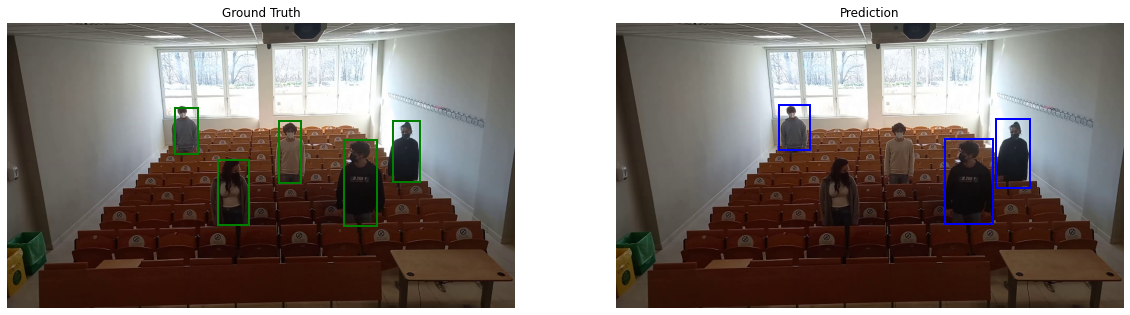

In [364]:
_, axs = plt.subplots(1, 2,figsize=(20, 10))
i = 0
random_idx=random.randint(0,test_set_size)
#random_idx=114
print("Index: ", random_idx)
show_img_with_boxes(test_set[random_idx], labels[random_idx][:-1], 'green', 'Ground Truth', axs[0])
show_img_with_boxes(test_set[random_idx], boxes[random_idx], 'blue', 'Prediction', axs[1])
print("Scial Distancing Respected: ", labels[random_idx][-1:] )

# Human Detection performance evaluation functions

In [16]:
def area(rect):
    return (rect[0] - rect[2]) * (rect[1] - rect[3])

def iou(label_box, pred_box):
    pred_area = area(pred_box)
    label_area = area(label_box)

    ix = min(label_box[3], pred_box[3]) - max(label_box[1], pred_box[1])
    iy = min(label_box[2], pred_box[2]) - max(label_box[0], pred_box[0])

    ix = max(ix, 0)
    iy = max(iy, 0)

    intersection = ix * iy

    union_area = pred_area + label_area - intersection
    union_area = max(union_area, np.finfo(float).eps)

    return intersection / union_area

def compute_tp_fp(_bboxes, labels, IOU_THR = 0.5):
    bboxes = _bboxes.copy()
    tp = []
    fp = []
    for gt_bbox in labels:
        overlaps = []
        for bbox in bboxes:
            overlaps.append(iou(gt_bbox, bbox))
        #print("Per la label: ", gt_bbox)
        #print("Overlaps: ", overlaps)
        if sum(overlaps) != 0:
            max_index = np.argmax(np.array(overlaps))
            #print("max overlap con: ", bboxes[max_index])
            if overlaps[max_index] >= IOU_THR:
                tp.append(1)
                fp.append(0)
                bboxes.pop(max_index)
            else:
                tp.append(0)
                fp.append(1)
        else:
            tp.append(0)
            fp.append(0)
        #print()
    return np.asarray(tp), np.asarray(fp)
    
def compute_class_tp_fp(boxes, labels):
    tp = []
    fp = []
    num_annotations = 0
    for b, l in zip(boxes, labels):
        lb = l[:-1]
        ftp, ffp = compute_tp_fp(b, lb)
        tp.extend(ftp)
        fp.extend(ffp)
        num_annotations = num_annotations + len(lb)
    return tp, fp, num_annotations

In [17]:
def compute_ap(recall, precision):
    #Compute the average precision, given the recall and precision curves.
    #Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
    #    recall:    The recall curve (list).
    #    precision: The precision curve (list).
    # Returns
    #    The average precision as computed in py-faster-rcnn.
    
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def compute_class_average_precision(true_positives,false_positives,num_annotations):
    if num_annotations == 0:
        return 0
    
    false_positives = np.cumsum(false_positives)
    true_positives = np.cumsum(true_positives)

    recall = true_positives / num_annotations

    precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

    return compute_ap(recall, precision)


In [236]:
ftp, ffp = compute_tp_fp(boxes[random_idx], labels[random_idx][:-1])
print(ftp, ffp)

[0 0 1 1 1] [0 1 0 0 0]


In [362]:
boxes, scores, classes = predict(model, test_set)
tp, fp, num_annotations = compute_class_tp_fp(boxes, labels)
ap = compute_class_average_precision(tp, fp, num_annotations)
print(ap)

ValueError: in user code:

    File "/public.hpc/marta.spadoni2/venv/lib/python3.7/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/public.hpc/marta.spadoni2/venv/lib/python3.7/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/public.hpc/marta.spadoni2/venv/lib/python3.7/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/public.hpc/marta.spadoni2/venv/lib/python3.7/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/public.hpc/marta.spadoni2/venv/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/public.hpc/marta.spadoni2/venv/lib/python3.7/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 300, 300, 3), found shape=(None, 562, 1000, 3)


In [ ]:
violation = []
masks = []
for bbox in boxes:
    frame_be_centroids = compute_bird_eye_centroids(bbox, matrix)
    cc, mask = check_centroids_distancing(frame_be_centroids, 9, target_width = test_set[0].shape[1])
    violation.append(any(mask))
    masks.append(mask)
decoded_violation = decode_violation_predictions(violation)

In [ ]:
ConfusionMatrixDisplay.from_predictions(violation_labels, decoded_violation, display_labels=class_names, normalize="true", cmap = "Blues")

## Perspective Matrix

In order to checking the social distancing the system needs the perspective matrix that allow to transform each frame in its corrisponding in the bird view.

Given an image of the empty room in which the social distancing must be checked, using the provided Python Script is possibile compute the matrix.

In the cell below a pre-calculated matrix will be load.

In [19]:
matrix = np.load("perspective_matrix.npy")
print(matrix)
bird_eye_frame = np.asarray(Image.open("bird_eye_frame.png"))[:,:,:3]

[[-6.88414613e+00 -7.26135962e+00  3.18990585e+03]
 [-2.92120913e-01 -1.28046334e+01  2.27226252e+03]
 [-4.05777507e-04 -1.81039292e-02  1.00000000e+00]]


Text(0.5, 1.0, 'Bird-eye View')

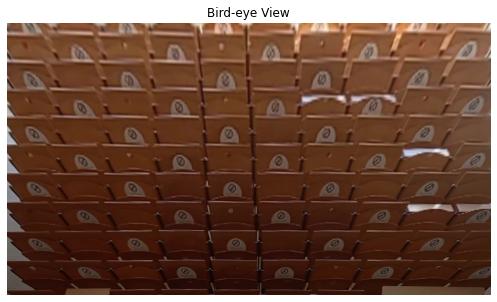

In [20]:
_, axs = plt.subplots(1, 1,figsize=(10, 5))
axs.imshow(bird_eye_frame)
axs.axis('off')
axs.set_title('Bird-eye View')

# Persective functions

In [21]:
def compute_perspective_matrix(upper_left, upper_right, bottom_left, bottom_right, image):
    corners = np.float32([upper_left, upper_right, bottom_left, bottom_right])
    h, w = TARGET_H, TARGET_W
    params = np.float32([[0, 0], [w, 0], [0, h], [w, h]])

    matrix = cv2.getPerspectiveTransform(corners, params)
    transformation = cv2.warpPerspective(image, matrix, (w,h))
    return matrix, transformation

def perspective_transform(matrix, image):
    h, w = TARGET_H, TARGET_W
    return cv2.warpPerspective(image, matrix, (w,h))

def get_bbox_centroid(box):
    y1, x1, y2, x2 = box[1], box[0], box[3], box[2]
    #return [(x1+x2)/2, (y1+y2)/2]
    return ((x1+x2)/2, y2)
  
def map_centroid(centroid, matrix):
    return cv2.perspectiveTransform(centroid, matrix)

def compute_bbox_centroids(detection_boxes):
    return [get_bbox_centroid(box) for box in detection_boxes]
  

def compute_bird_eye_centroids(detection_boxes, matrix):
    detection_centroids = compute_bbox_centroids(detection_boxes)
    mapped_centroids = [map_centroid(np.array([np.array([centroid])]), matrix) for centroid in detection_centroids]
    mapped_centroids = [(int(centroid[0][0][0]), int(centroid[0][0][1])) for centroid in mapped_centroids]
    return mapped_centroids


# Social Distancing functions

In [168]:
def compute_safe_distance_in_px(real_width, target_width, SAFE_DISTANCE_THR_METER = 1):
    safe_distance = (target_width * SAFE_DISTANCE_THR_METER)/real_width
    return safe_distance
    #return 110

def distance_between(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def check_centroids_distancing(frame_centroids, real_width, target_width = 800):
    checked_centroids = []
    mask = []
    couples = [couple for couple in iter.combinations(frame_centroids, 2)]
    for couple in couples:
        distance = distance_between(couple[0], couple[1])
        violation = distance <= compute_safe_distance_in_px(real_width, target_width)
        #print("Couple: ", couple, "Violate Social distancing: ", violation)
        checked_centroids.append((couple, violation))
        mask.append(violation)

    return checked_centroids, mask

def check_boxes_distancing(frame_boxes, mask):
    checked_boxes = []
    red = []
    couples = [couple for couple in iter.combinations(frame_boxes, 2)]
    for i, couple in enumerate(couples):
        if mask[i]:
            red.append([couple[0][0], couple[0][1], couple[0][2], couple[0][3]])
            red.append([couple[1][0], couple[1][1], couple[1][2], couple[1][3]])
    for b in frame_boxes:
        checked_boxes.append((b, (255, 0, 0) if b in red else (0, 255, 0)))
    return checked_boxes

In [462]:
def draw_centroids_on_frame(frame, frame_centroids, color = (0,0,255), with_social_distancing = False):
    for centroid in frame_centroids:
        centroid = (int(centroid[0]), int(centroid[1]))
        frame = cv2.circle(frame, centroid, 4, color, -1)
        if with_social_distancing:
            frame = cv2.circle(frame, centroid, 50, color, 2)
    return frame

def draw_centroids_on_bird_eye_frame(bird_eye_frame, bird_eye_centroids):
    frame = bird_eye_frame.copy()
    if frame is None:
        print("ERROR")
    red = []
    green = []
    for c in bird_eye_centroids:
        if c[1]:
            red.append(c[0][0])
            red.append(c[0][1])
        else :
            if c[0][0] not in red:
                green.append(c[0][0])
            if c[0][1] not in red:
                green.append(c[0][1])
    frame = draw_centroids_on_frame(frame, list(set(red)), with_social_distancing=True)
    frame = draw_centroids_on_frame(frame, list(set(green).difference(red)), (0, 255, 0), True)
    return frame

def draw_checked_boxes_on_frame(frame, checked_boxes):
    _img = frame.copy()
    for b in checked_boxes:
        start_point = (b[0][0], b[0][1])
        end_point = (b[0][2], b[0][3])
        cv2.rectangle(_img, start_point, end_point, b[1], 1)
    return _img


def draw_centroids_and_line_on_frame(frame_boxes, mask):
    frame = np.zeros((450,800,3),dtype=np.uint8) 
    centroids = []
    for c in compute_bbox_centroids(frame_boxes):
        centroids.append((int(c[0]), int(c[1])))
    red = []
    couples = [couple for couple in iter.combinations(centroids, 2)]
    for i, couple in enumerate(couples):
        if mask[i]:
            red.append(couple[0])
            red.append(couple[1])
            frame = cv2.circle(frame, couple[0], 6, (0,0,255), -1)
            frame = cv2.circle(frame, couple[1], 6, (0,0,255), -1)
            frame = cv2.line(frame, couple[0], couple[1], (0,0,255), 4)

    green = set(centroids).difference(set(red))
    for g in green:
        frame = cv2.circle(frame, g, 4, (0,255, 0), -1)

    return frame

In [289]:
def check_social_distancing_on_frame(frame, detection_boxes, matrix, bird_eye_frame, REAL_ROOM_WIDTH = 9):
    bird_eye_centroids = compute_bird_eye_centroids(detection_boxes, matrix)
    checked_be_centroids, mask = check_centroids_distancing(bird_eye_centroids, REAL_ROOM_WIDTH)
    frame_centroids = compute_bbox_centroids(detection_boxes)
    checked_frame = draw_checked_boxes_on_frame(frame, check_boxes_distancing(detection_boxes, mask))
    boxed_frame = draw_centroids_on_frame(checked_frame, frame_centroids)
    simulation_frame = draw_centroids_on_bird_eye_frame(bird_eye_frame, checked_be_centroids)
    lines_frame = draw_centroids_and_line_on_frame(detection_boxes, mask)
    return boxed_frame, simulation_frame, lines_frame

# Social Distancing Verification - Perfomance Evaluation

In [525]:
def ssd300_predict(model, test_set, confidence_thr):
    boxes = []
    scores = []
    classes = []
    for img in test_set:
        img_res = cv2.resize(img, (300,300), interpolation = cv2.INTER_AREA)
        pb, ps, pc = select_preds(model.predict(img_res[np.newaxis,:,:,:]), img.shape, confidence_thr, selected_class = 15)
        boxes.append(pb)
        scores.append(ps)
        classes.append(pc)
    return boxes, scores, classes

def evaluate_model_speed(model_dict, matrix, confidence_thr):
    model = model_dict['model']
    frame_number = 50
    start_time = time.time()
    bbox, s, c = predict(model, test_set[0:frame_number], confidence_thr) if model_dict['model_name'] != 'ssd300' else ssd300_predict(model, test_set[0:frame_number], confidence_thr)
    detection_speed = (time.time() - start_time)/frame_number
    model_dict['detection_speed'] = detection_speed
    for i in range(frame_number):
        frame_be_centroids = compute_bird_eye_centroids(bbox[i], matrix)
        cc, mask = check_centroids_distancing(frame_be_centroids, 9, target_width = test_set[0].shape[1])
        violation = any(mask)

    execution_speed = (time.time() - start_time)/frame_number
    model_dict['execution_speed'] = execution_speed
    return model_dict

def evaluate_model_ap(model_dict, test_set, labels, confidence_thr):
    model = model_dict['model']
    boxes, scores, classes = predict(model, test_set, confidence_thr) if model_dict['model_name'] != 'ssd300' else ssd300_predict(model, test_set, confidence_thr)
    tp, fp, num_annotations = compute_class_tp_fp(boxes, labels)
    ap = compute_class_average_precision(tp, fp, num_annotations)
    model_dict['ap'] = ap
    return model_dict

def decode_violation_predictions(preds):
    return [1-int(p) for p in preds]


def model_predictions(model_dict, test_set, matrix, confidence_thr):
    model = model_dict['model']
    violation = []
    masks = []
    boxes, scores, classes = predict(model, test_set, confidence_thr) if model_dict['model_name'] != 'ssd300' else ssd300_predict(model, test_set, confidence_thr)
    for bbox in boxes:
        frame_be_centroids = compute_bird_eye_centroids(bbox, matrix)
        cc, mask = check_centroids_distancing(frame_be_centroids, 9, target_width = test_set[0].shape[1])
        violation.append(any(mask))
        masks.append(mask)
    preds = decode_violation_predictions(violation)
    model_dict['boxes'] = boxes
    model_dict['predictions'] = preds
    model_dict['masks'] = masks
    return model_dict

def model_fp(model_preds, labels):
    fp = []
    for i in range(test_set_size):
        if model_preds[i] == 1 and labels[i] == 0:
            fp.append(i)
    return fp

def model_fn(model_preds, labels):
    fn = []
    for i in range(test_set_size):
        if model_preds[i] == 0 and labels[i] == 1:
            fn.append(i)
    return fn

def show_model_fp_fn(model_dict, test_set, violation_labels, save=False):
    boxes = model_dict['boxes']
    masks = model_dict['masks']
    model = model_dict["model_name"]
    fig, axs = plt.subplots(1, 2,figsize=(20, 10))
    fp = model_fp(model_dict['predictions'], violation_labels)
    fn = model_fn(model_dict['predictions'], violation_labels)
    
    idx_fp = random.choice(fp)
    idx_fn = random.choice(fn)
    
    fp_frame = test_set[idx_fp]
    cb = check_boxes_distancing(boxes[idx_fp], masks[idx_fp])
    fp_frame = draw_checked_boxes_on_frame(fp_frame, cb)
    
    fn_frame = test_set[idx_fn]
    cb = check_boxes_distancing(boxes[idx_fn], masks[idx_fn])
    fn_frame = draw_checked_boxes_on_frame(fn_frame, cb)
 
    show_img(fp_frame, 'False Positive: ' + str(idx_fp), axs[0])
    show_img(fn_frame, 'False Negative: ' + str(idx_fn), axs[1])
    
    fig.suptitle('Model: ' + model, fontsize=16, y=0.8)
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('fpfn/'+model+".png")



In [517]:
matrix = np.load("perspective_matrix.npy")
confidence_thr = 0.45
for model_dict in models_list:
    print("Evaluating model:", model_dict['short_name'])
    model_dict = evaluate_model_speed(model_dict, matrix, confidence_thr)
    model_dict = evaluate_model_ap(model_dict, test_set, labels, confidence_thr)
    model_dict = model_predictions(model_dict, test_set, matrix, confidence_thr)

Evaluating model: ssd_mobilenetV2_fpnlite
Evaluating model: cn_resnet50V2


2022-03-30 09:31:58.951816: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/Assert_1/AssertGuard/branch_executed/_345


Evaluating model: cn_resnet50V1_fpn


2022-03-30 09:32:09.767986: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/Assert/AssertGuard/branch_executed/_378


Evaluating model: ssd_mobilenetV2
Evaluating model: efficientdet_d0
Evaluating model: cn_resnet101V1_fpn


2022-03-30 09:34:04.893021: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/Assert/AssertGuard/branch_executed/_684


Evaluating model: ssd300


In [523]:
df = pd.DataFrame(models_list).sort_values(by=['ap'], ascending=False)
print(df[['short_name', 'ap']].to_markdown(index=False))

| short_name              |       ap |
|:------------------------|---------:|
| cn_resnet101V1_fpn      | 0.921227 |
| cn_resnet50V1_fpn       | 0.913972 |
| efficientdet_d0         | 0.907447 |
| cn_resnet50V2           | 0.853472 |
| ssd_mobilenetV2_fpnlite | 0.788238 |
| ssd_mobilenetV2         | 0.654942 |
| ssd300                  | 0.443307 |


In [540]:
df = df.sort_values(by=['execution_speed'])
print(df[['short_name', 'detection_speed', 'execution_speed']].to_markdown())

|    | short_name              |   detection_speed |   execution_speed |
|---:|:------------------------|------------------:|------------------:|
|  2 | cn_resnet50V1_fpn       |         0.0396334 |         0.0396652 |
|  1 | cn_resnet50V2           |         0.0404905 |         0.0405207 |
|  5 | cn_resnet101V1_fpn      |         0.0569272 |         0.0569564 |
|  6 | ssd300                  |         0.076545  |         0.0765672 |
|  3 | ssd_mobilenetV2         |         0.115968  |         0.116     |
|  0 | ssd_mobilenetV2_fpnlite |         0.167798  |         0.167828  |
|  4 | efficientdet_d0         |         0.281306  |         0.281338  |


In [501]:
!pip install tabulate --no-cache-dir

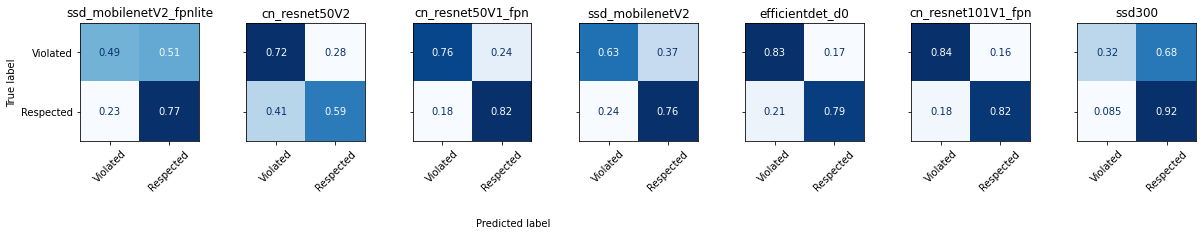

In [534]:
class_names = ["Violated", "Respected"]
f, axes = plt.subplots(1, 7, figsize=(20, 5), sharey='row')

for i, model_dict in enumerate(models_list):
    cf_matrix = confusion_matrix(violation_labels, model_dict['predictions'], normalize="true")
    tn, fp, fn, tp = confusion_matrix(violation_labels, model_dict['predictions']).ravel()
    model_dict['errors'] = -(fp+tp)
    disp = ConfusionMatrixDisplay(cf_matrix, display_labels=class_names)
    disp.plot(ax=axes[i], xticks_rotation=45, cmap="Blues")
    disp.ax_.set_title(model_dict['short_name'])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


#f.colorbar(disp.im_, ax=axes)
plt.show()


ssd_mobilenetV2_fpnlite -102


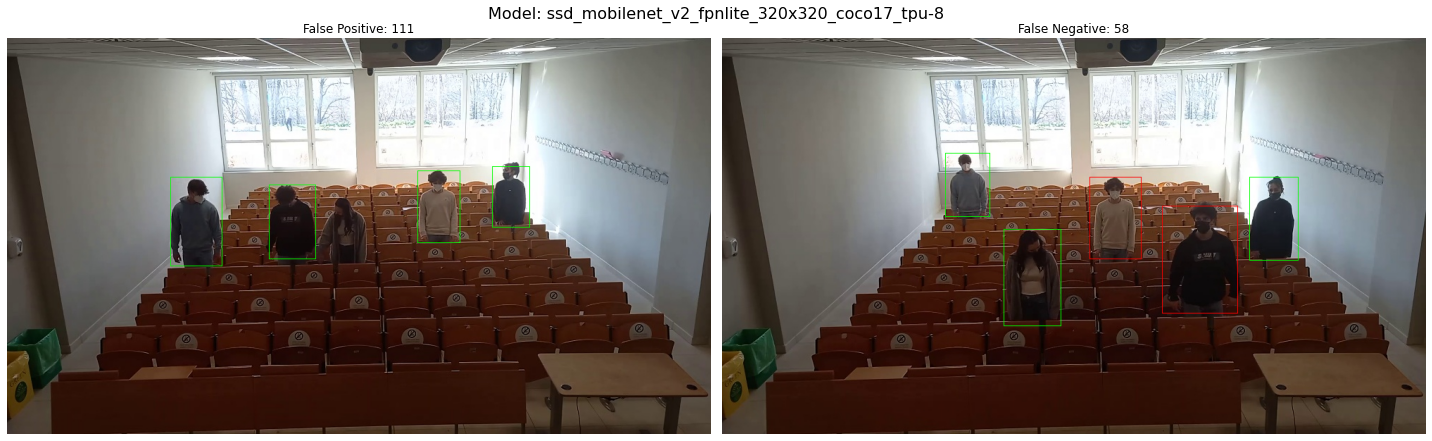

cn_resnet50V2 -68


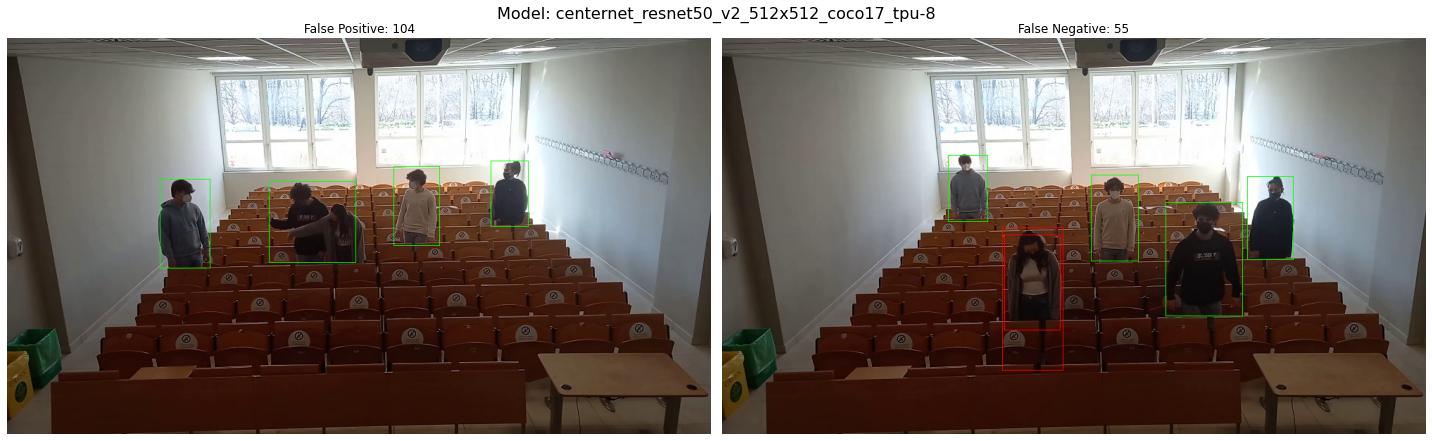

cn_resnet50V1_fpn -80


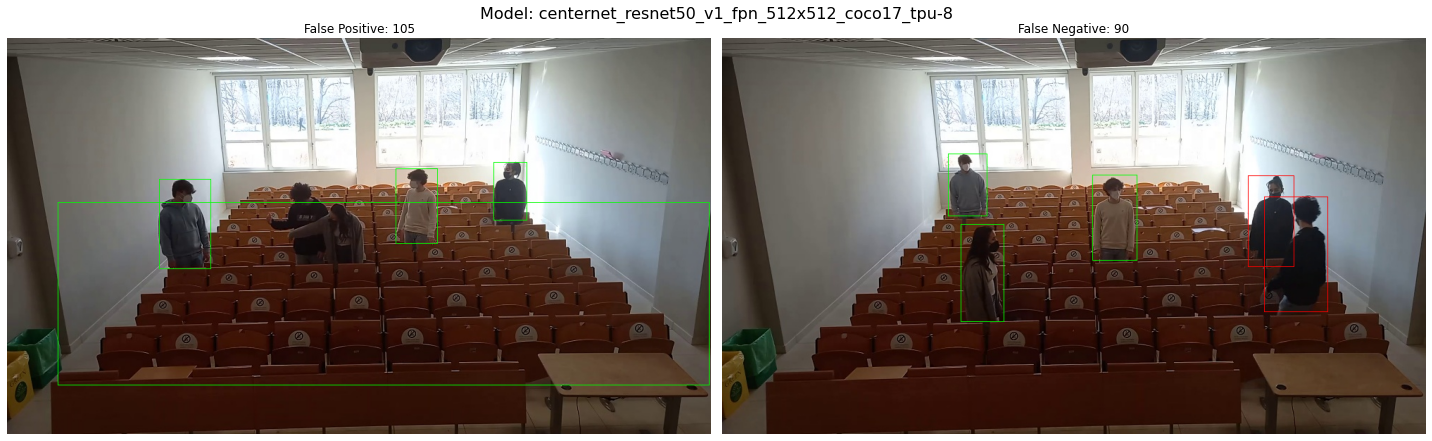

ssd_mobilenetV2 -88


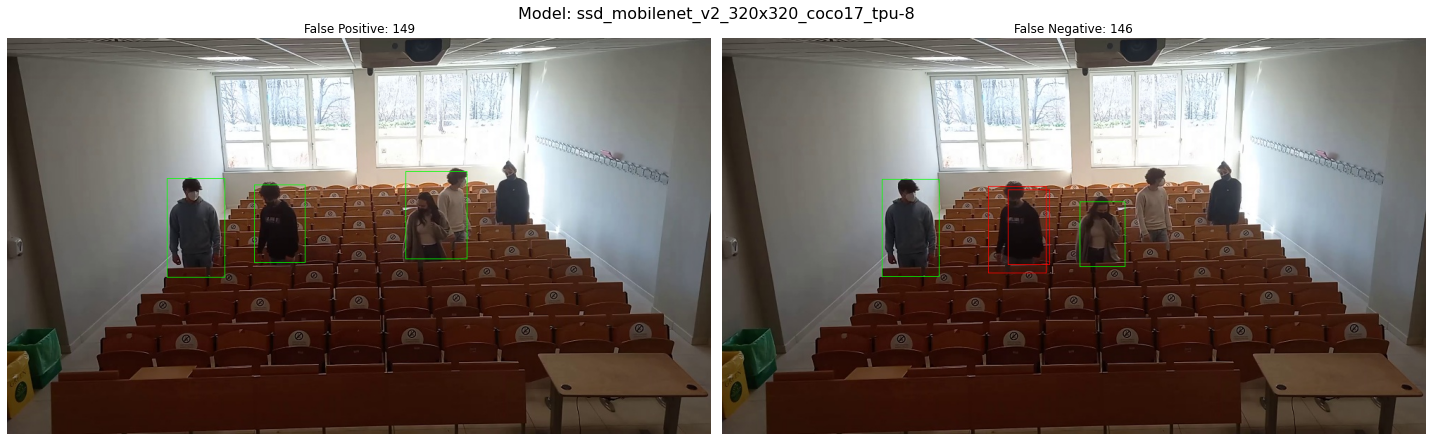

efficientdet_d0 -72


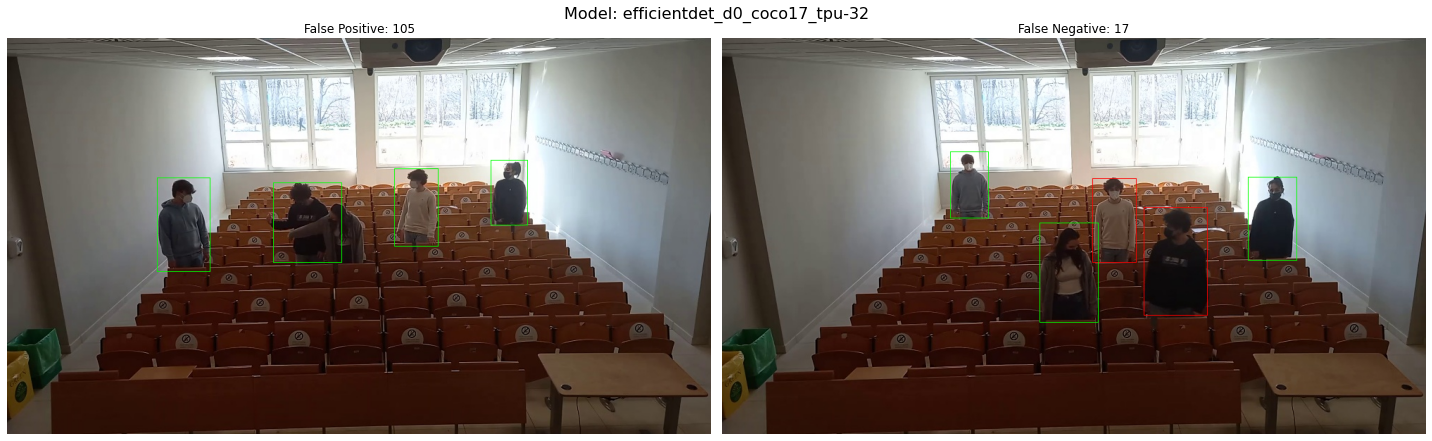

cn_resnet101V1_fpn -73


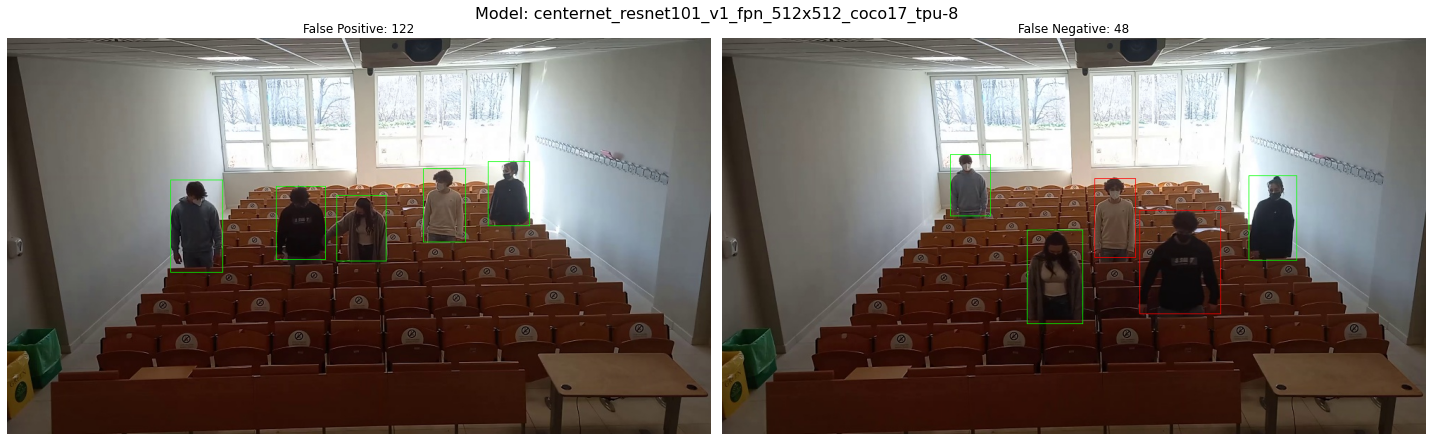

ssd300 -128


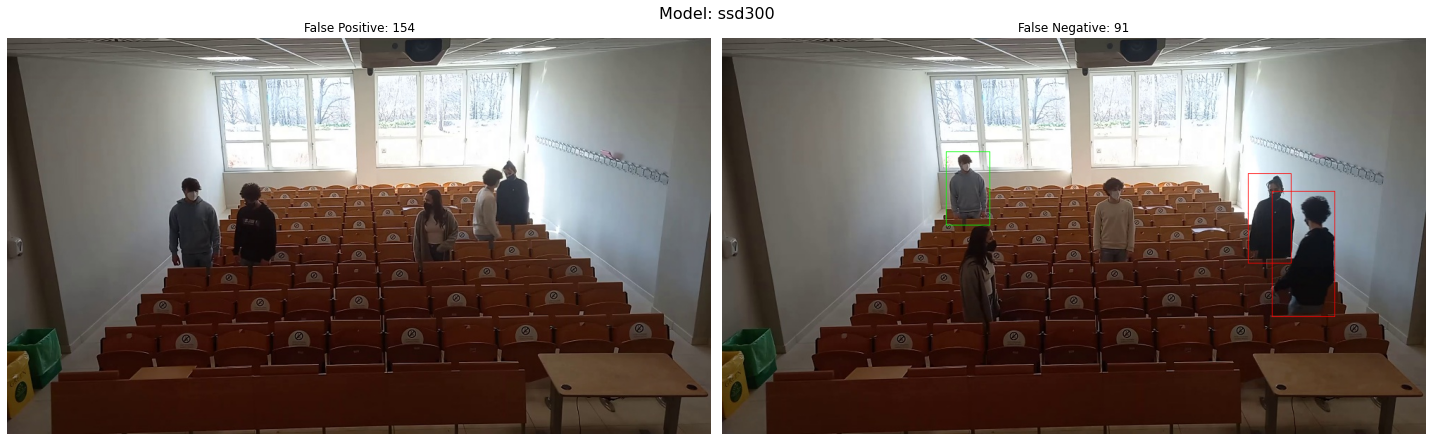

In [535]:
for model_dict in models_list:
    show_model_fp_fn(model_dict, test_set, violation_labels)

In [554]:
for md in models_list:
    md['execution_speed'] = - abs(md['execution_speed'])

In [559]:
df = pd.DataFrame(models_list).sort_values(by=['execution_speed', 'ap', 'errors'], ascending=False)
print(df[['short_name', 'execution_speed', 'ap', 'errors']].to_markdown(index=False))

| short_name              |   execution_speed |       ap |   errors |
|:------------------------|------------------:|---------:|---------:|
| cn_resnet50V1_fpn       |        -0.0396652 | 0.913972 |      -80 |
| cn_resnet50V2           |        -0.0405207 | 0.853472 |      -68 |
| cn_resnet101V1_fpn      |        -0.0569564 | 0.921227 |      -73 |
| ssd300                  |        -0.0765672 | 0.443307 |     -128 |
| ssd_mobilenetV2         |        -0.116     | 0.654942 |      -88 |
| ssd_mobilenetV2_fpnlite |        -0.167828  | 0.788238 |     -102 |
| efficientdet_d0         |        -0.281338  | 0.907447 |      -72 |


# Video Functions


In [12]:
def get_video_frames(video_path, rotate_right=False, TARGET_W = 800, TARGET_H = 450):
    vid = cv2.VideoCapture(video_path)
    frames = []

    while(vid.isOpened()):
        ret, fr = vid.read()
        if ret == True:
            fr = cv2.resize(fr, (TARGET_W, TARGET_H))
            if rotate_right:
                fr = cv2.rotate(fr, cv2.cv2.ROTATE_90_CLOCKWISE)
            frames.append(fr)
        else:
            break

    vid.release()
    return frames

def save_video(frames, video_path="video.avi", TARGET_W = 800, TARGET_H = 450):
    out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), 30, (TARGET_W, TARGET_H))
    for i in range(len(frames)):
        out.write(frames[i])
    out.release()


Dowloading perspective matrix from Google Drive, it is required for bird-eye transformation

This is the matrix for "Room5" videos: https://drive.google.com/drive/folders/1rXkP4zsy9OgmF5r5LDcSlNR3hhqZj5_h?usp=sharing

In [13]:
!gdown --id "1u0wMQRNDj09Xbq7DvmUI-jRUrLrTwYMg"
matrix = np.load("perspective_matrix.npy")

Downloading...
From: https://drive.google.com/uc?id=1u0wMQRNDj09Xbq7DvmUI-jRUrLrTwYMg
To: /content/perspective_matrix.npy
100% 200/200 [00:00<00:00, 356kB/s]


In [14]:
!gdown --id "1n9XbrtqkIk4kuAMFrK0YVYsPIvvYwLpu"
bird_eye_frame = cv2.imread("bird_eye_frame.png")

Downloading...
From: https://drive.google.com/uc?id=1n9XbrtqkIk4kuAMFrK0YVYsPIvvYwLpu
To: /content/bird_eye_frame.png
100% 414k/414k [00:00<00:00, 2.96MB/s]


In [15]:
!gdown --id "1bSzlglrlynmW5bWNdsLKh4NutYuOLZcW"
frames = get_video_frames("room5-triple-mini.mp4")

Downloading...
From: https://drive.google.com/uc?id=1bSzlglrlynmW5bWNdsLKh4NutYuOLZcW
To: /content/room5-triple-mini.mp4
100% 1.09M/1.09M [00:00<00:00, 6.08MB/s]


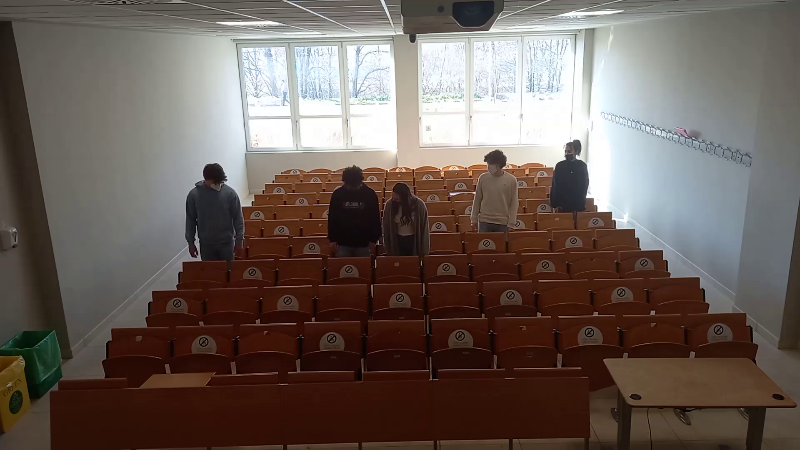

In [16]:
cv2_imshow(frames[0])

In [17]:
def check_on_video_frames(model, frames, bird_eye_frame, matrix, output_video_name = "room5", REAL_ROOM_WIDTH = 9):
    simulation_frames = []
    boxed_frames = []
    lines_frames = []
    print("Inference started...")
    for frame in frames:
        _, _, detection_boxes= detect(model, frame)
        bird_eye_centroids = compute_bird_eye_centroids(detection_boxes, matrix)
        checked_be_centroids, mask = check_centroids_distancing(bird_eye_centroids, REAL_ROOM_WIDTH)
        frame_centroids = compute_bbox_centroids(detection_boxes)
        checked_frame = draw_checked_boxes_on_frame(frame, check_boxes_distancing(detection_boxes, mask))
        boxed_frames.append(draw_centroids_on_frame(checked_frame, frame_centroids))
        simulation_frames.append(draw_centroids_on_bird_eye_frame(bird_eye_frame, checked_be_centroids))
        lines_frames.append(draw_centroids_and_line_on_frame(detection_boxes, mask))
    print("Inference ended, saving videos...")

    if len(boxed_frames) > 0:
        save_video(boxed_frames, output_video_name+"-boxed.avi") 
    if len(simulation_frames) > 0:
        save_video(simulation_frames, output_video_name+"-simulation.avi")
    if len(lines_frames) > 0:
        save_video(lines_frames, output_video_name+"-lines.avi")
    return boxed_frames, simulation_frames, lines_frames


In [18]:
boxed, simulation, lines = check_on_video_frames(model, frames, bird_eye_frame, matrix)

Inference started...
Inference ended, saving videos...
